# Negative L1 norm prior experiment

This code attempts to learn the 8D prior
$J(x) = -||x||_1$
assuming we have access to training data $\{y_i, S(y_i)\}$, $S(y_i) = -t/2 - |x|$

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/NegL1_prior_8D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,t=1.0):
    # Negative L1 Norm J(x) = -||x||_1
    # S(x, t) = -t/2 - |x| (per dimension)
    # For n dimensions: S(x, t) = - (n*t)/2 - ||x||_1
    
    dim = y.shape[1]
    l1_norm = np.sum(np.abs(y), axis=1)
    return -(t) / 2.0 - l1_norm


def prior_true(y):
    # J(x) = -||x||_1
    return -np.sum(np.abs(y), axis=1)


def cvx_true(y,t=1.0):
    '''
    Computes Psi(y) = 0.5*||y||^2 - S(y,t).
    The target convex function to learn.
    '''
    return 0.5 * euclid_norm_sq(y) - hjsol_true(y, t)


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,t=1.0) 
    x2_0_cvx_true = cvx_true(x2_0_points,t=1.0)

    x1_0_prior_true = prior_true(x1_0_points)
    x2_0_prior_true = prior_true(x2_0_points)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_cvx_est, "-", label="LPN")
    plt.plot(xi, x1_0_cvx_true, "--", label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the convex function, Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('Convex functions $(x_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_cvx_est, "-", label="LPN")
        plt.plot(xi, x2_0_cvx_true, "--", label="Ref")
        plt.grid(True)
        plt.title(f"Cross sections ($0,x_2$,0) of the convex function, Dim {dim}",fontsize=16)
        plt.xlabel('$x_2$',fontsize=16)
        plt.ylabel('Convex functions $(0,x_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_prior_est, "-",label="LPN")
    plt.plot(xi, x1_0_prior_true, "-",label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the prior function,Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('Prior functions ($x_1$,0)',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_prior_est, "-", label="LPN")
        plt.plot(xi, x2_0_prior_true, "-", label="Ref")
        plt.grid("on")
        plt.title(f"Cross sections ($0,x_2$,0) of the prior function,Dim {dim}",fontsize=16)
        plt.xlabel('$x_1$',fontsize=16)
        plt.ylabel('Prior functions ($0,x_2$,0)',fontsize=16)
        plt.legend()
    plt.tight_layout()

def plot_all(model,a,spacing,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 8

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 30000
Iterations = 500000

# LPN model parameters
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,t=1.0).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-3
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 1557.20263671875
iteration 0 loss 35.63762664794922


iteration 5000 loss 0.050908926874399185


iteration 10000 loss 0.04115969315171242


iteration 15000 loss 0.03397151082754135


iteration 20000 loss 0.029345914721488953


iteration 25000 loss 0.025029854848980904


iteration 30000 loss 0.025869442149996758


iteration 35000 loss 0.17630022764205933


iteration 40000 loss 0.016977770254015923


iteration 45000 loss 0.015242846682667732


iteration 50000 loss 0.053083039820194244


iteration 55000 loss 0.012243438512086868


iteration 60000 loss 0.011630279943346977


iteration 65000 loss 0.010328924283385277


iteration 70000 loss 0.012639561668038368


iteration 75000 loss 0.00871239509433508


iteration 80000 loss 0.008146869949996471


iteration 85000 loss 0.0076101236045360565


iteration 90000 loss 0.00717496033757925


iteration 95000 loss 0.007062491495162249


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.006430856883525848


iteration 105000 loss 0.02434679865837097


iteration 110000 loss 0.005787129979580641


iteration 115000 loss 0.005510588642209768


iteration 120000 loss 0.0052803512662649155


iteration 125000 loss 0.005069670733064413


iteration 130000 loss 0.0048781028017401695


iteration 135000 loss 0.004708076361566782


iteration 140000 loss 0.0045465403236448765


iteration 145000 loss 0.004403602331876755


iteration 150000 loss 0.004265177063643932


iteration 155000 loss 0.004140152130275965


iteration 160000 loss 0.004024420864880085


iteration 165000 loss 0.0039193169213831425


iteration 170000 loss 0.003822528989985585


iteration 175000 loss 0.004247978329658508


iteration 180000 loss 0.003649848746135831


iteration 185000 loss 0.0035718989092856646


iteration 190000 loss 0.0035001521464437246


iteration 195000 loss 0.0034331989008933306


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.0033703623339533806


iteration 205000 loss 0.003346280427649617


iteration 210000 loss 0.0032930609304457903


iteration 215000 loss 0.00324304960668087


iteration 220000 loss 0.0031945505179464817


iteration 225000 loss 0.0031494300346821547


iteration 230000 loss 0.0031046615913510323


iteration 235000 loss 0.00306430971249938


iteration 240000 loss 0.003024409059435129


iteration 245000 loss 0.0029858287889510393


iteration 250000 loss 0.0029485172126442194


iteration 255000 loss 0.0029130694456398487


iteration 260000 loss 0.0028796412516385317


iteration 265000 loss 0.002847020048648119


iteration 270000 loss 0.0028169280849397182


iteration 275000 loss 0.0027864258736371994


iteration 280000 loss 0.0027565297205001116


iteration 285000 loss 0.002729125088080764


iteration 290000 loss 0.0027014287188649178


iteration 295000 loss 0.002674807794392109


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.0026487039867788553


iteration 305000 loss 0.0026385465171188116


iteration 310000 loss 0.0026138366665691137


iteration 315000 loss 0.002589241601526737


iteration 320000 loss 0.002566213021054864


iteration 325000 loss 0.002543496200814843


iteration 330000 loss 0.002521480666473508


iteration 335000 loss 0.002499845577403903


iteration 340000 loss 0.0024791895411908627


iteration 345000 loss 0.0024587756488472223


iteration 350000 loss 0.0024388364981859922


iteration 355000 loss 0.0024191485717892647


iteration 360000 loss 0.002400135388597846


iteration 365000 loss 0.0023808206897228956


iteration 370000 loss 0.0023631048388779163


iteration 375000 loss 0.0023446569684892893


iteration 380000 loss 0.0023260184098035097


iteration 385000 loss 0.002308016177266836


iteration 390000 loss 0.00229065865278244


iteration 395000 loss 0.002273533260449767


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 0.0022566334810107946


iteration 405000 loss 0.002251650206744671


iteration 410000 loss 0.002243650145828724


iteration 415000 loss 0.0022358025889843702


iteration 420000 loss 0.0022280970588326454


iteration 425000 loss 0.002220483496785164


iteration 430000 loss 0.0022129432763904333


iteration 435000 loss 0.002205483615398407


iteration 440000 loss 0.002198100322857499


iteration 445000 loss 0.0021907715126872063


iteration 450000 loss 0.0021835104562342167


iteration 455000 loss 0.0021763204131275415


iteration 460000 loss 0.0021691881120204926


iteration 465000 loss 0.0021621144842356443


iteration 470000 loss 0.0021550736855715513


iteration 475000 loss 0.002148091560229659


iteration 480000 loss 0.0021411683410406113


iteration 485000 loss 0.002134306589141488


iteration 490000 loss 0.0021275021135807037


iteration 495000 loss 0.0021207486279308796


L2 loss -- Plot

loss 221.08160400390625


loss 155.6505584716797


loss 122.37385559082031


loss 101.1614990234375


loss 87.17424011230469


loss 78.36103820800781


loss 73.36774444580078


loss 70.9241714477539


loss 69.91142272949219


loss 69.561767578125


loss 69.46444702148438


loss 69.44390869140625


loss 69.44091033935547


loss 69.44063568115234


loss 69.44062805175781


loss 69.44062805175781


loss 69.44062042236328


loss 69.44062042236328


loss 69.44061279296875


loss 69.44062042236328


loss 69.44061279296875


loss 69.44061279296875


loss 69.44062805175781


loss 69.44062042236328


loss 69.44062805175781


loss 69.44062805175781


loss 69.44062805175781


loss 69.44062042236328


loss 69.44063568115234


loss 69.44062805175781


loss 69.44062042236328


loss 69.44062805175781


loss 69.44061279296875


loss 69.44062805175781


loss 69.44062042236328


loss 69.44062042236328


loss 69.44062805175781


loss 69.44062805175781


loss 69.44062805175781


loss 69.44062805175781


final mse:  9.223040109418434e-09
max, min: 3.0227594 -3.0780196
loss 221.08160400390625


loss 156.91094970703125


loss 124.73221588134766


loss 104.2246322631836


loss 90.77435302734375


loss 82.34461975097656


loss 77.52980041503906


loss 75.11003112792969


loss 74.07410430908203


loss 73.70992279052734


loss 73.60987091064453


loss 73.58982849121094


loss 73.5871810913086


loss 73.58697509765625


loss 73.58697509765625


loss 73.58695983886719


loss 73.58695983886719


loss 73.58695983886719


loss 73.58695983886719


loss 73.58696746826172


loss 73.58696746826172


loss 73.58695983886719


loss 73.58695983886719


loss 73.58695983886719


loss 73.58695983886719


loss 73.58695983886719


loss 73.58695983886719


loss 73.58695983886719


loss 73.58695983886719


loss 73.58695220947266


loss 73.58695983886719


loss 73.58695983886719


loss 73.58695983886719


loss 73.58695983886719


loss 73.58695983886719


loss 73.58695220947266


loss 73.58695983886719


loss 73.58695983886719


loss 73.58695983886719


loss 73.58695983886719


final mse:  6.3121761151307965e-09
max, min: 3.0208585 -3.0698206


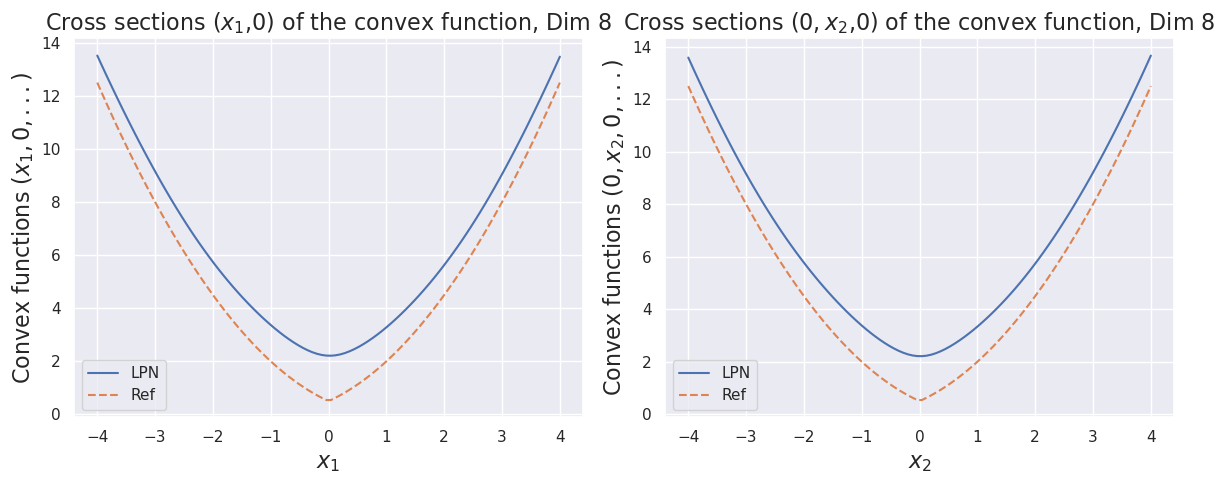

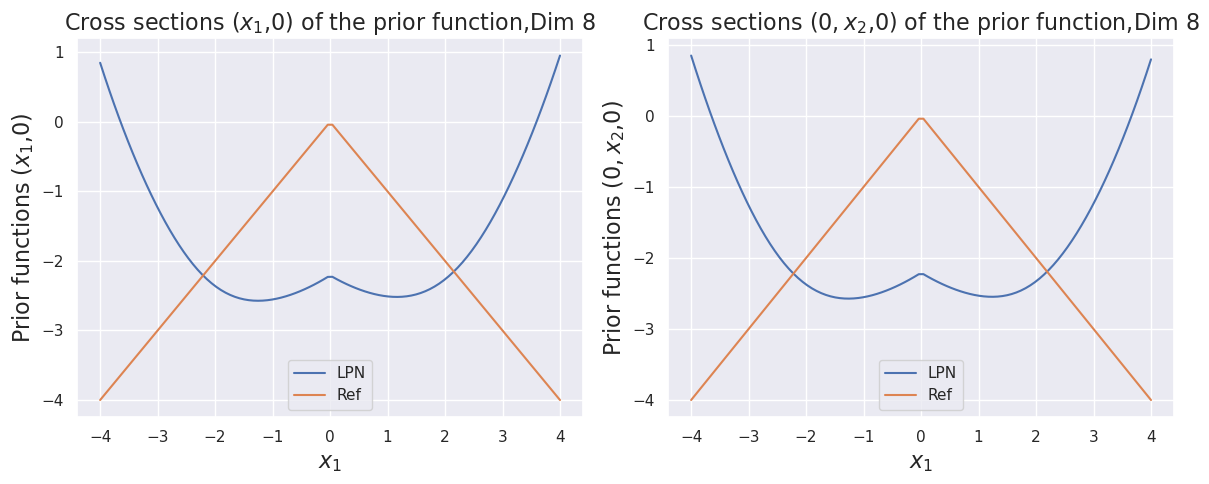

In [7]:
plot_all(lpn_model,a,spacing,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

G_samples_tensor = G_samples_tensor_with_graph.detach().to(device)

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)

# --- Train 2nd LPN ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-3 
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of 2nd LPN complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 478.0631103515625
iteration 0 loss 1073.305419921875


iteration 5000 loss 0.2966538965702057


iteration 10000 loss 0.1981116086244583


iteration 15000 loss 0.13156658411026


iteration 20000 loss 0.07526645809412003


iteration 25000 loss 0.664874255657196


iteration 30000 loss 0.04015573114156723


iteration 35000 loss 0.01900077983736992


iteration 40000 loss 0.01277221366763115


iteration 45000 loss 0.009182408452033997


iteration 50000 loss 0.0074307844042778015


iteration 55000 loss 0.006291841622442007


iteration 60000 loss 0.005404317285865545


iteration 65000 loss 0.004942388739436865


iteration 70000 loss 0.003954841289669275


iteration 75000 loss 0.003439639462158084


iteration 80000 loss 0.00491894269362092


iteration 85000 loss 0.002699970966205001


iteration 90000 loss 0.002370057860389352


iteration 95000 loss 0.002073113340884447


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.001931814826093614


iteration 105000 loss 0.0016715815290808678


iteration 110000 loss 0.0014486429281532764


iteration 115000 loss 0.0018484346801415086


iteration 120000 loss 0.0011618486605584621


iteration 125000 loss 0.0030719914939254522


iteration 130000 loss 0.0009798221290111542


iteration 135000 loss 0.0009135226137004793


iteration 140000 loss 0.0008546755416318774


iteration 145000 loss 0.000806103169452399


iteration 150000 loss 0.0007638800307177007


iteration 155000 loss 0.0007273135706782341


iteration 160000 loss 0.0010148792061954737


iteration 165000 loss 0.0006676676566712558


iteration 170000 loss 0.0006428011693060398


iteration 175000 loss 0.0009126446093432605


iteration 180000 loss 0.0006005584727972746


iteration 185000 loss 0.000582717009820044


iteration 190000 loss 0.0005662351613864303


iteration 195000 loss 0.0005514957592822611


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.0006437460542656481


iteration 205000 loss 0.0005328495753929019


iteration 210000 loss 0.0005205449997447431


iteration 215000 loss 0.0005097328685224056


iteration 220000 loss 0.000498548150062561


iteration 225000 loss 0.0004888264811597764


iteration 230000 loss 0.00047985059791244566


iteration 235000 loss 0.00047196043306030333


iteration 240000 loss 0.00046419751015491784


iteration 245000 loss 0.00045702766510657966


iteration 250000 loss 0.0004500627692323178


iteration 255000 loss 0.0004439654294401407


iteration 260000 loss 0.00043826212640851736


iteration 265000 loss 0.00043277416261844337


iteration 270000 loss 0.00042749804561026394


iteration 275000 loss 0.00042241939809173346


iteration 280000 loss 0.0004176170041318983


iteration 285000 loss 0.000412980152759701


iteration 290000 loss 0.0004088672867510468


iteration 295000 loss 0.0004046190297231078


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.0004008114628959447


iteration 305000 loss 0.00039889494655653834


iteration 310000 loss 0.0003948744561057538


iteration 315000 loss 0.00039079494308680296


iteration 320000 loss 0.0003872052184306085


iteration 325000 loss 0.000383532140403986


iteration 330000 loss 0.0003803115978371352


iteration 335000 loss 0.00037699591484852135


iteration 340000 loss 0.00037369015626609325


iteration 345000 loss 0.00037055008579045534


iteration 350000 loss 0.00036767928395420313


iteration 355000 loss 0.0003650844155345112


iteration 360000 loss 0.0003624487144406885


iteration 365000 loss 0.00035983696579933167


iteration 370000 loss 0.0003575544978957623


iteration 375000 loss 0.00035521239624358714


iteration 380000 loss 0.0003527978260535747


iteration 385000 loss 0.000350695860106498


iteration 390000 loss 0.00034861519816331565


iteration 395000 loss 0.0003464742039795965


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 0.00034465143107809126


iteration 405000 loss 0.0003440282307565212


iteration 410000 loss 0.0003422024310566485


iteration 415000 loss 0.0003403715090826154


iteration 420000 loss 0.0003386089811101556


iteration 425000 loss 0.00033690722193568945


iteration 430000 loss 0.0003352625062689185


iteration 435000 loss 0.0003336699737701565


iteration 440000 loss 0.0003321178664918989


iteration 445000 loss 0.0003306070575490594


iteration 450000 loss 0.0003291344328317791


iteration 455000 loss 0.00032769935205578804


iteration 460000 loss 0.00032629925408400595


iteration 465000 loss 0.0003249316359870136


iteration 470000 loss 0.000323597778333351


iteration 475000 loss 0.000322295178193599


iteration 480000 loss 0.0003210261056665331


iteration 485000 loss 0.0003197841579094529


iteration 490000 loss 0.00031856613350100815


iteration 495000 loss 0.00031737290555611253


Training of 2nd LPN complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


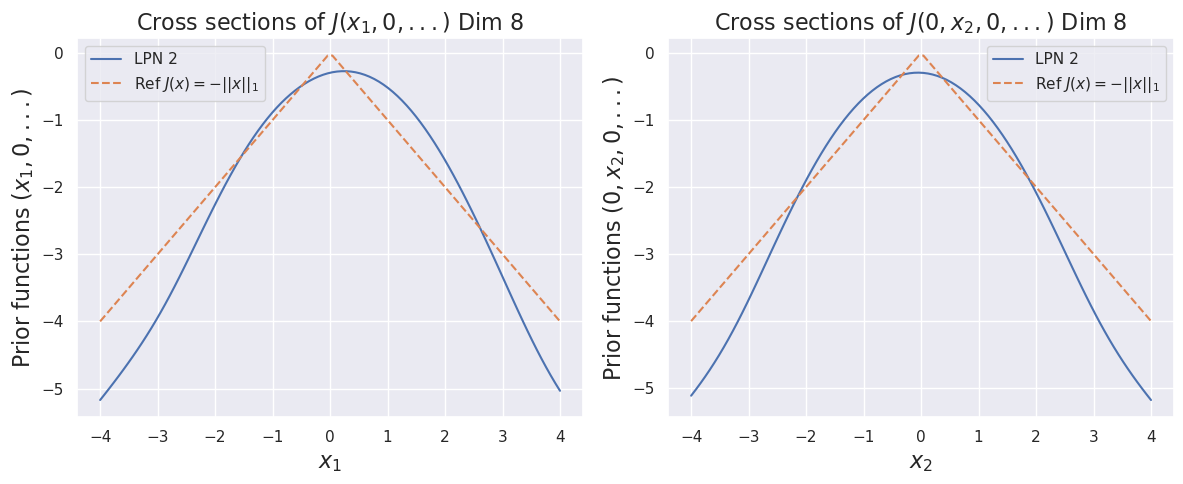

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=-||x||_1$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('Prior functions $(x_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=-||x||_1$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}",fontsize=16)
        plt.xlabel('$x_2$',fontsize=16)
        plt.ylabel('Prior functions $(0,x_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim)